In [7]:
import tensorflow as tf
import numpy as np

X = np.random.rand(2,100).astype("float32")
Y = np.dot([0.1,0.2],X)+0.3
bias = tf.Variable(tf.zeros([1]))
W = tf.Variable(tf.random_uniform([1,2],-1.0,1.0))
y = tf.add(tf.matmul(W,X), bias)
loss = tf.reduce_mean(tf.square(y-Y))
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
for step in range(0, 1000):
    sess.run(train)
    if step%100==0:
        print("step: " , step, " loss: " , sess.run(loss), sess.run(W), sess.run(bias))

step:  0  loss:  0.052340258 [[0.41855884 0.60662246]] [-0.23592322]
step:  100  loss:  2.6484398e-07 [[0.1010092  0.20141523]] [0.29871234]
step:  200  loss:  2.2967494e-12 [[0.10000296 0.20000418]] [0.2999962]
step:  300  loss:  1.731948e-15 [[0.10000008 0.20000012]] [0.2999999]
step:  400  loss:  1.731948e-15 [[0.10000008 0.20000012]] [0.2999999]
step:  500  loss:  1.731948e-15 [[0.10000008 0.20000012]] [0.2999999]
step:  600  loss:  1.731948e-15 [[0.10000008 0.20000012]] [0.2999999]
step:  700  loss:  1.731948e-15 [[0.10000008 0.20000012]] [0.2999999]
step:  800  loss:  1.731948e-15 [[0.10000008 0.20000012]] [0.2999999]
step:  900  loss:  1.731948e-15 [[0.10000008 0.20000012]] [0.2999999]


Cost after epoch 0: 1.921825
Cost after epoch 5: 1.904152
Cost after epoch 10: 1.904319
Cost after epoch 15: 1.904581
Cost after epoch 20: 1.904157
Cost after epoch 25: 1.904098
Cost after epoch 30: 1.752994
Cost after epoch 35: 1.641618
Cost after epoch 40: 1.591664
Cost after epoch 45: 1.589229
Cost after epoch 50: 1.477437
Cost after epoch 55: 1.302648
Cost after epoch 60: 1.193441
Cost after epoch 65: 1.171850
Cost after epoch 70: 1.080340
Cost after epoch 75: 1.069238
Cost after epoch 80: 1.021812
Cost after epoch 85: 1.006125
Cost after epoch 90: 0.964422
Cost after epoch 95: 0.936594


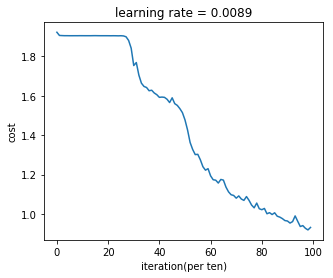

Tensor("Mean_1:0", shape=(), dtype=float32)
train accuracy:  0.68796295
test accuracy:  0.55833334


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import math
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops


plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

def zero_pad(X, pad):
    X_pad = np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)),'constant')
    return X_pad

def conv_single_step(a_slice_prev, W, b):
    '''
    a_slice_prev:slice of input data of shape(f,f,n_C_prev)
    W: shape (f,f,n_C_prev)
    b: shape (1,1,1)
    '''
    s = a_slice_prev * W
    Z = np.sum(s)
    Z = Z+b
    return Z

def conv_forward(A_prev, W, b, hparams):
    (m,n_H_prev,n_W_prev,n_C_prev) = A_prev.shape
    (f,f,n_c_prev,n_C) = W.shape
    stride = hparams['stride']
    pad = hparams['pad']
    
    n_H = int((n_H_prev+2*pad-f)/stride+1)
    n_W = int((n_W_prev+2*pad-f)/stride+1)
    
    Z = np.zeros((m,n_H,n_W,n_C))
    
    A_prev_pad = zero_pad(A_prev,pad)
    
    for i in range(m):
        a_prev_pad = A_prev_pad[i,:,:,:]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    
                    vert_start = stride*h
                    vert_end = vert_start+f
                    horiz_start = stride*w
                    horiz_end = horiz_start+f
                    
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    Z[i,h,w,c] = conv_single_step(a_slice_prev,W[:,:,:,c],b[:,:,:,c])
    cache = (A_prev,W,b,hparams)
    return Z,cache

def pool_forward(A_prev,hparams,mode='max'):
    (m,n_H_prev,n_W_prev,n_C_prev) = A_prev.shape
    f = hparams['f']
    stride = hparams['stride']
    
    n_H = int((n_H_prev-f)/stride + 1)
    n_W = int((n_W_prev-f)/stride + 1)
    n_C = n_C_prev
    
    A = np.zeros((m,n_H,n_W,n_C))
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    
                    vert_start = h*stride
                    vert_end = vert_start + f
                    horiz_start = w*stride
                    horiz_end = horiz_start + f
                    
                    a_prev_slice = A_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]
                    if mode == "max":
                        A[i,h,w,c] = np.max(a_prev_slice)
                    elif mode == 'average':
                        A[i,h,w,c] = np.mean(a_prev_slice)
    cache = (A_prev, hparams)
    return A, cache

def conv_backward(dZ, cache):
    (A_prev,W,b,hparams) = cache
    (m,n_H_prev,n_W_prev,n_C_prev) = A_prev.shape
    (f,f,n_C_prev,n_C) = W.shape
    
    stride = hparams['stride']
    pad = hparams['pad']
    
    (m,n_H,n_W,n_C) = dZ.shape
    
    dA_prev = np.zeros((m,n_H_prev,n_W_prev,n_C_prev))
    dW = np.zeros((f,f,n_C_prev,n_C))
    db = np.zeros((1,1,1,n_C))
    
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):
        a_prev_pad = A_prev_pad[i,:,:,:]
        da_prev_pad = dA_prev_pad[i,:,:,:]
        
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    a_slice = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    da_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:] += W[:,:,:,C]*dZ[i,h,w,c]
                    dW[:,:,:,c] += a_slice * dZ[i,h,w,c]
                    db[:,:,:,c] += dZ[i,h,w,c]
        dA_prev[i,:,:,:] = da_prev_pad[pad:-pad,pad:-pad,:]
    return dA_prev, dW, db

def create_mask_from_window(x):
    mask = (x == np.max(x))
    return mask

def distribute_value(dz, shape):
    (n_H, n_W) = shape
    average = dz /(n_H*n_W)
    a = average * np.ones(shape)
    return a

def pool_backward(dA, cache, mode='max'):
    (A_prev, hparams) = cache
    stride = hparams["stride"]
    f = hparams['f']

    m,n_H_prev,n_W_prev,n_C_prev = A_prev.shape
    m,n_H,n_W,n_C = dA.shape

    dA_prev = np.zeros(np.shape(A_prev))
    for i in range(m):
        a_prev = A_prev[i,:,:,:]

        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f

                    if mode == 'max':
                        a_prev_slice = a_prev[vert_start:vert_end,horiz_start:horiz_end,c]
                        mask = create_mask_from_window(a_prev_slice)
                        dA_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]+=np.multiply(mask,dA[i,h,w,c])
                    elif mode == 'average':
                        da = dA[i,h,w,c]
                        shape = (f,f)
                        dA_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]+=distribute_value(da, shape)
    return dA_prev

# use tensorflow
def load_dataset():
    train_dataset = h5py.File('E://project/data/tensorflow_tutorial_train_signs.h5', 'r')
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('E://project/data/tensorflow_tutorial_test_signs.h5', 'r')
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset['list_classes'][:])

    train_set_y_orig = train_set_y_orig.reshape((1,train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1,test_set_y_orig.shape[0]))
    return train_set_x_orig,train_set_y_orig,test_set_x_orig,test_set_y_orig,classes

def convert_to_one_hot(Y,C):
    return np.eye(C)[Y.reshape(-1)].T

def process_dataset(X_train_orig, Y_train_orig, X_test_orig, Y_test_orig):
    X_train = X_train_orig/255
    X_test = X_test_orig/255
    Y_train = convert_to_one_hot(Y_train_orig, 6).T
    Y_test = convert_to_one_hot(Y_test_orig, 6).T
    return X_train, Y_train, X_test, Y_test

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, shape=[None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, shape=[None, n_y])
    return X, Y

def init_params():
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1",[4,4,3,8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2",[2,2,8,16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    params = {"W1":W1, "W2":W2}
    return params

def forward_propagation(X, params):
    W1 = params["W1"]
    W2 = params["W2"]
     
    # strides=[1,s,s,1]  ksize=[1,f,f,1]
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding="SAME")
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize=[1,8,8,1], strides=[1,8,8,1], padding="SAME")
    
    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding="SAME")
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides=[1,4,4,1], padding="SAME")
    # into a 1D vector while maintaining the batch_size
    # returns a flattened tensor with shape [batch_size,k]
    P2 = tf.contrib.layers.flatten(P2)
    
    # without an non-linear activation function
    # 5 neurons in output layers
    # hint:one of the arguments should be "activation_fn=None"
    Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn = None)
    return Z3

def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
    return cost

def model(X_train, Y_train, X_test, Y_test, learning_rate=0.0089,
         num_epoches=100, minibatch_size=64, print_cost=True):
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    
    params = init_params()
    Z3 = forward_propagation(X, params)
    
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epoches):
            minibatch_cost = 0
            num_minibatches = int(m/minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _, temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                minibatch_cost += temp_cost/num_minibatches
                
            if print_cost and epoch%5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost and epoch%1 == 0:
                costs.append(minibatch_cost)
                
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iteration(per ten)')
        plt.title("learning rate = " + str(learning_rate))
        plt.show()

        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X:X_train, Y:Y_train})
        test_accuracy = accuracy.eval({X:X_test, Y:Y_test})
        print("train accuracy: ", train_accuracy)
        print("test accuracy: ", test_accuracy)
        return train_accuracy, test_accuracy, params
    
# def random_mini_batches(X,Y,mini_batch_size=64,seed=0):
#     m = X.shape[1]
#     mini_batches = []
#     np.random.seed(seed)

#     permutation = list(np.random.permutation(m))
#     shuffled_X = X[:,permutation]
#     print(Y.shape)
#     print(permutation)
#     shuffled_Y = Y[:,permutation].reshape((Y.shape[0],m))

#     num_complete_minibatches= math.floor(m/mini_batch_size)
#     for k in range(0, num_complete_minibatches):
#         mini_batch_X = shuffled_X[:,k*mini_batch_size:(k+1)*mini_batch_size]
#         mini_batch_Y = shuffled_Y[:,k*mini_batch_size:(k+1)*mini_batch_size]
#         mini_batches.append((mini_batch_X,mini_batch_Y))
#     if m%mini_batch_size!=0:
#         mini_batch_X = shuffled_X[:,num_complete_minibatches*mini_batch_size:m]
#         mini_batch_Y = shuffled_Y[:,num_complete_minibatches*mini_batch_size:m]
#         mini_batches.append((mini_batch_X,mini_batch_Y))
#     return mini_batches

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    m = X.shape[0]                 
    mini_batches = []
    np.random.seed(seed)

    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches

if __name__ == "__main__":
    X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
#     index = 6
#     plt.imshow(X_train_orig[index])
#     print("y="+str(np.squeeze(Y_train_orig[:,index])))
    X_train, Y_train, X_test, Y_test = process_dataset(X_train_orig, Y_train_orig, X_test_orig, Y_test_orig)
    _,_,params = model(X_train, Y_train, X_test, Y_test)